In [2]:
!pip install langgraph graphviz ipython
!pip install langchain-groq python-dotenv langgraph langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.33
    Uninstalling langchain-core-0.3.33:
      Successfully uninstalled langchain-core-0.3.33
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.5
    Uninstalling langchain-text-splitters-0.3.5:
      Successfully uninstalled langchain-text-splitters-0.3.5
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.17
    Uninstalling langchain-0.3.17:
      Successfully uninstalled langchain-0.3.17


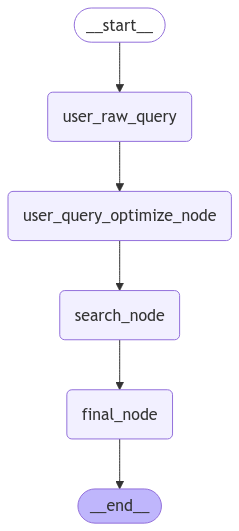

Welcome to the Research Chatbot!
Type 'quit' to exit the chat
--------------------------------------------------

Enter research query: hybrid model using RAG and CAG
---------------------node1------------------------
Raw user query: hybrid model using RAG and CAG
---------------------node2------------------------
Optimized query: ("hybrid model" AND ("RAG" OR "CAG")) AND (research OR academic OR journal OR publication OR study OR paper)

---------------------node3------------------------
Found 2 search results

---------------------node4------------------------
Source 1: https://www.linkedin.com/posts/abhishek-pan_cag-research-paper-activity-7280882277541203968-4Z-T
Content: While this may not spell the end for RAG, CAG undoubtedly ... RAG (Retrieval-Augmented Generation) is a powerful hybrid model that

Source 2: https://sumitpat.medium.com/the-rag-revolution-how-retrieval-augmented-generation-is-transforming-nlp-6f914f73b130
Content: RAG stands for Retrieval-Augmented Generation. It

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import Graph
from typing import List, Dict

load_dotenv()
os.environ["GROQ_API_KEY"] = "...."


llm = ChatGroq(
    model_name="llama-3.3-70b-versatile",
    temperature=0.5
)

def user_raw_query(input_1: str) -> str:

    print(f"---------------------node1------------------------")
    print(f"Raw user query: {input_1}")
    return input_1

def user_query_optimize_node(input_2: str) -> str:

    print(f"---------------------node2------------------------")
    prompt = f'''Modify this query for internet search to find research-focused results: "{input_2}"
    Return only the optimized search query without any additional text.'''
    response = llm.invoke(prompt).content
    print(f"Optimized query: {response}\n")
    return response

def search_node(input_3: str) -> List[Dict]:

    print(f"---------------------node3------------------------")
    os.environ["TAVILY_API_KEY"] = "...."
    max=2
    search = TavilySearchResults(max_results=max,search_depth="advanced")
    results = search.invoke(input_3)
    print(f"Found {len(results)} search results\n")
    return results

def final_node(input_4: List[Dict]) -> str:

    print(f"---------------------node4------------------------")
    sources = "\n".join([f"Source {i+1}: {result['url']}\nContent: {result['content']}\n"
                        for i, result in enumerate(input_4)])
    print(sources)
    prompt = f'''Generate a detailed research report based on the following sources:

{sources}

Format the report as follows:
1. Executive Summary
2. Key Findings
3. Detailed Analysis
4. Trends and Insights
5. Citations

Ensure all information is properly cited using [Source X] format.'''

    response = llm.invoke(prompt).content
    print("Research report generated successfully\n")
    return response

workflow = Graph()

workflow.add_node("user_raw_query", user_raw_query)
workflow.add_node("user_query_optimize_node", user_query_optimize_node)
workflow.add_node("search_node", search_node)
workflow.add_node("final_node", final_node)

workflow.add_edge("user_raw_query", "user_query_optimize_node")
workflow.add_edge("user_query_optimize_node", "search_node")
workflow.add_edge("search_node", "final_node")

workflow.set_entry_point("user_raw_query")
workflow.set_finish_point("final_node")

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

def chat_loop():
    print("Welcome to the Research Chatbot!")
    print("Type 'quit' to exit the chat")
    print("-" * 50)

    while True:

        user_query = input("\nEnter research query: ")


        if user_query.lower() in ['quit', 'exit', 'bye']:
            print("Thank you for using the Research Chatbot!")
            break

        try:

            result = app.invoke(user_query)


            print("\nHere's research report:\n")
            print(result)
            print("\n" + "-" * 50)

        except Exception as e:
            print(f"\nAn error occurred: {str(e)}")
            print("Please try again with a different query.")

if __name__ == "__main__":
    chat_loop()